# Chapter 11 - Notes

## Set Up

### Packages

In [149]:
import os

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from scipy import stats
from scipy.special import logit, expit
from sklearn.preprocessing import StandardScaler

### Defaults

In [3]:
# seaborn defaults
sns.set(
    style="whitegrid",
    font_scale=1.2,
    rc={
        "axes.edgecolor": "0",
        "axes.grid.which": "both",
        "axes.labelcolor": "0",
        "axes.spines.right": False,
        "axes.spines.top": False,
        "xtick.bottom": True,
        "ytick.left": True,
    },
)

colors = sns.color_palette()

### Constants

In [4]:
DATA_DIR = "../data"
HOWELL_FILE = "howell.csv"
CHERRY_BLOSSOMS_FILE = "cherry_blossoms.csv"
WAFFLE_DIVORCE_FILE = "waffle_divorce.csv"
MILK_FILE = "milk.csv"
CHIMPANZEES_FILE = "chimpanzees.csv"

RANDOM_SEED = 42

In [5]:
def load_data(file_name, data_dir=DATA_DIR, **kwargs):
    path = os.path.join(data_dir, file_name)
    return pd.read_csv(path, **kwargs)

## 11.1 Binomial regresssion

### 11.1.1 Logistic regression: Prosocial chimpanzees

In [69]:
# load the data
chimps = load_data(CHIMPANZEES_FILE, delimiter=";")

Start with the simplified model. We plot the prior on $p$ for different priors on $\alpha$

In [104]:
def sample_constant_model_prior(chimps, alpha_prior_sigma):
    with pm.Model():
        # prior
        alpha = pm.Normal("alpha", mu=0, sigma=alpha_prior_sigma)

        # model
        p = pm.Deterministic("p", pm.math.invlogit(alpha))

        # likelihood
        pulled_left = pm.Binomial("pulled_left", n=1, p=p, observed=chimps.pulled_left)

        # sample prior predictive
        pp_trace = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
    
    return pp_trace

Sampling: [alpha, pulled_left]
Sampling: [alpha, pulled_left]
Sampling: [alpha, pulled_left]
Sampling: [alpha, pulled_left]
Sampling: [alpha, pulled_left]


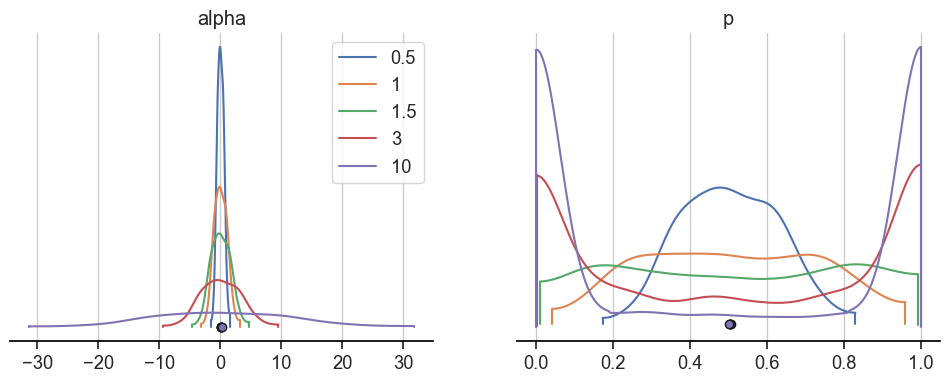

In [113]:
sigmas = [0.5, 1, 1.5, 3, 10]
traces = []
for sigma in sigmas:
    traces.append(sample_constant_model_prior(chimps, sigma))
    
pm.plot_density(
    traces,
    group="prior",
    data_labels=sigmas,
    var_names=["alpha", "p"],
    hdi_prob=1,
    figsize=(12, 4),
);

Now we create an index variable for treatment.
We also need to create an index for `actor` so that it goes from 0.

In [80]:
chimps["treatment_idx"] = chimps["prosoc_left"] + 2*chimps["condition"]

treatment_mapper = {
    0: "R/N",
    1: "L/N",
    2: "R/P",
    3: "L/P",
}
chimps["treatment"] = chimps["treatment_idx"].replace(treatment_mapper)

chimps["actor_idx"] = chimps["actor"] - 1

Now do the same but with a fixed $\alpha$ and different priors on $\beta$.

In [120]:
def sample_no_agent_effect_model_prior(chimps, beta_prior_sigma):
    treatments = chimps.sort_values("treatment_idx").treatment.unique()
    coords = {
        "treatment": treatments,
    }
    with pm.Model(coords=coords):
        # data
        treatment_idx = pm.MutableData("treatment", chimps.treatment_idx, dims="obs")

        # priors
        alpha = pm.Normal("alpha", mu=0, sigma=1.5)
        beta = pm.Normal("beta", mu=0, sigma=beta_prior_sigma, dims="treatment")
        
        # left/right treatment effect
        diff_between_treatments = pm.Deterministic(
            "diff_between_treatments",
            pm.math.abs(
                pm.math.invlogit(alpha + beta[1]) - pm.math.invlogit(alpha + beta[0])
            ),
        )

        # linear model
        p = pm.Deterministic("p", pm.math.invlogit(alpha + beta[treatment_idx]), dims="obs")

        # likelihood
        pulled_left = pm.Binomial("pulled_left", n=1, p=p, observed=chimps.pulled_left, dims="obs")

        # sample the prior predictive
        trace = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
    
    
    return trace

Sampling: [alpha, beta, pulled_left]
Sampling: [alpha, beta, pulled_left]
Sampling: [alpha, beta, pulled_left]
Sampling: [alpha, beta, pulled_left]
Sampling: [alpha, beta, pulled_left]


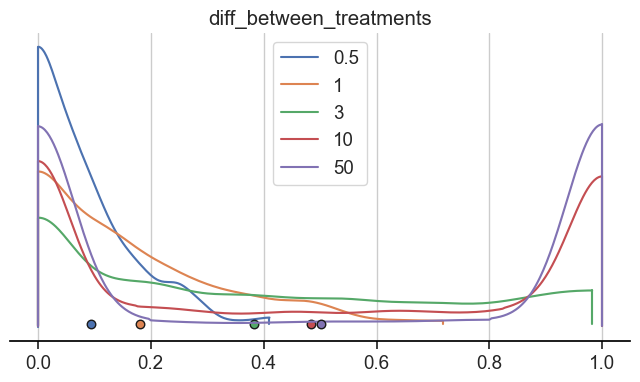

In [131]:
sigmas = [0.5, 1, 3, 10, 50]
traces = []
for sigma in sigmas:
    traces.append(sample_no_agent_effect_model_prior(chimps, sigma))
    
pm.plot_density(
    traces,
    group="prior",
    data_labels=sigmas,
    var_names=["diff_between_treatments"],
    hdi_prob=1,
    figsize=(8, 4),
);

Finally let's do a sensible model

In [134]:
actors = chimps.sort_values("actor_idx").actor.unique()
treatments = chimps.sort_values("treatment_idx").treatment.unique()
coords = {
    "actor": actors,
    "treatment": treatments,
}
with pm.Model(coords=coords) as m11_3:
    # data
    actor_idx = pm.MutableData("actor", chimps.actor_idx, dims="obs")
    treatment_idx = pm.MutableData("treatment", chimps.treatment_idx, dims="obs")
    
    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=1.5, dims="actor")
    beta = pm.Normal("beta", mu=0, sigma=0.5, dims="treatment")
    
    # linear model
    p = pm.Deterministic("p", pm.math.invlogit(alpha[actor_idx] + beta[treatment_idx]), dims="obs")

    # likelihood
    pulled_left = pm.Binomial("pulled_left", n=1, p=p, observed=chimps.pulled_left, dims="obs")
    
    # sample the prior predictive
    trace_11_3 = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Summarise posteriors

In [139]:
az.summary(
    trace_11_3,
    var_names=["alpha", "beta"],
    kind="stats",
    hdi_prob=0.97,
    round_to=2
)

,mean,sd,hdi_1.5%,hdi_98.5%
alpha[1],-0.44,0.33,-1.21,0.22
alpha[2],3.91,0.76,2.34,5.62
alpha[3],-0.74,0.33,-1.47,-0.04
alpha[4],-0.74,0.33,-1.47,-0.04
alpha[5],-0.45,0.33,-1.24,0.21
alpha[6],0.48,0.34,-0.22,1.26
alpha[7],1.96,0.42,1.07,2.86
beta[R/N],-0.05,0.29,-0.66,0.58
beta[L/N],0.47,0.28,-0.13,1.09
beta[R/P],-0.39,0.28,-0.99,0.22


Now we compare the posteriors for the $\alpha$ values and their inverse logits (i.e. actual probability values)

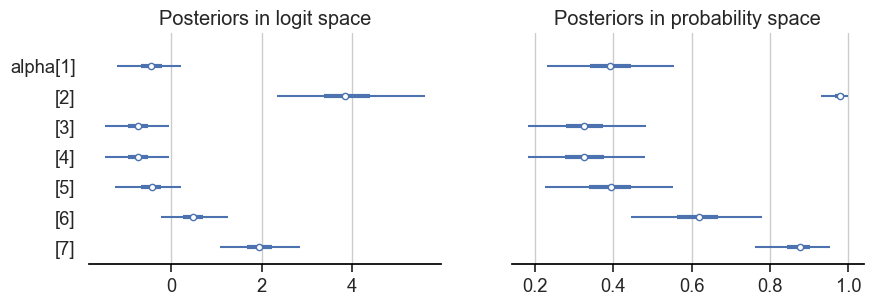

In [152]:
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(10, 3))

az.plot_forest(
    trace_11_3,
    var_names=["alpha"],
    hdi_prob=0.97,
    combined=True,
    ax=axs[0],
)
axs[0].set_title("Posteriors in logit space")

az.plot_forest(
    expit(trace_11_3.posterior.alpha),
    hdi_prob=0.97,
    combined=True,
    ax=axs[1],
)
axs[1].set_title("Posteriors in probability space");

Now the treatment effect, controlling for individual agent.

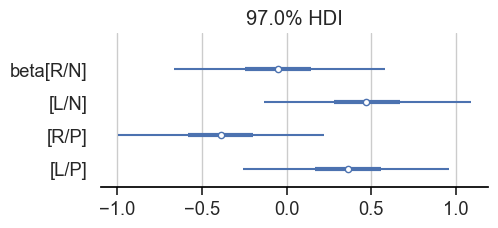

In [155]:
az.plot_forest(
    trace_11_3,
    var_names=["beta"],
    hdi_prob=0.97,
    combined=True,
    figsize=(5, 2),
);

Let's plot the contrasts

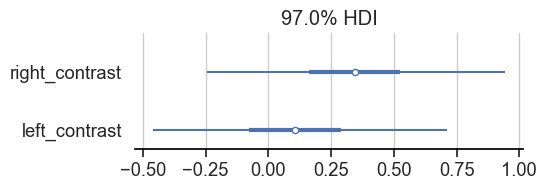

In [163]:
trace_11_3.posterior["right_contrast"] = trace_11_3.posterior.beta.sel(treatment="R/N") - trace_11_3.posterior.beta.sel(treatment="R/P")
trace_11_3.posterior["left_contrast"] = trace_11_3.posterior.beta.sel(treatment="L/N") - trace_11_3.posterior.beta.sel(treatment="L/P")

az.plot_forest(
    trace_11_3,
    var_names=["contrast"],
    filter_vars="regex",
    hdi_prob=0.97,
    combined=True,
    figsize=(5, 1.5),
);